# Trabalho prático II - Classificação

O objetivo deste trabalho é praticar os conceitos de aprendizado supervisionado que vimos em sala.

A sua tarefa será treinar um classificador para um conjunto de dados misterioso (se eu falasses qual é o objetivo do modelo, você encontraria soluções na Internet).

Baixe o arquivo [t2.tar.gz](https://drive.google.com/file/d/125plHKUzFGxHjjCiVJcTQG2bPG_zgDNV/view?usp=sharing). Descoprima este arquivo para encontrar outros quatro. Os arquivos `train_X.csv` e `train_y.csv` possuem os dados que você deve usar para treinar o modelo. O arquivo `test_X.csv` possui os objetos para os quais você deve encontrar as classes (testar o modelo). Por fim, o arquivo `test_example_y.csv` é um exemplo de como sua solução final deve ser organizada.

Cada linha dos arquivos `train_X.csv` e `test_X.csv` tem 15 campos descrevendo um objeto misterioso. O campo `id` representa o identificador do objeto, sendo que este campo não deve ser considerado em seu modelo. Os atributos a serem usados no modelo são os 14 campos rotulados de de `a` até `n`. Desses atributos:
- `b`, `d`, `f`, `g`, `h`, `i`, `j` e `n` são categóricos; e
- `a`, `c`, `e`, `k`, `l` e `m` são numéricos.

Cada linha do arquivo `train_y.csv` possui dois campos. O primeiro é o identificador de um objeto do arquivo `train_X.csv` e o segundo é a classe do respectivo objeto (0 ou 1).

Seu objetivo é encontrar as classes dos objetos do arquivo `test_X.csv` e mostrar como chegou em sua solução! Os dados do arquivo de teste foram obtido a partir de uma amostra aleatório do todo. Ou seja, um modelo bem treinado, e sem _overfitting_, em `train_X.csv` e `train_y.csv` se sairá bem em `test_X.csv`.

**Data de entrega:** dia 4 de julho de 2018.

**Grupo:** de até 3 pessoas, mas duas pessoas do mesmo grupo no trabalho 1 não podem pertencer ao mesmo grupo nesse trabalho.

**Valor:** 20% da nota do semestre.

Os três seguintes pontos descrevem o que obrigatoriamente deve ser entregue, com seu respectivo valor.

1 - **[10 pontos]** Este notebook com todo seu código e resultados (números, tabelas e gráficos). Você pode usar qualquer um dos métodos que estudamos ou alguma de suas variações próximas. Se estiver na dúvida se pode usar um método, basta perguntas no Piazza. Comentários e justificativas no notebook não serão considerados para sua nota.
O notebook deve ser enviado para o email do professor.

2 - **[8 pontos]** Um relatório digitado contendo: capa, introdução, metodologia, resultados, conclusão e referências. O relatório deve ter no máximo 10 páginas, com coluna simples, fonte 11, espaçamento 1.5 e margens de 2cm. A seção de metodologia deve conter uma descrição detalhada dos passos seguidos (não incluir código no relatório). A seção de resultados deve conter obrigatoriamente: uma caracterização descritiva dos dados, matriz de confusão das predições, _precision_, _recall_, _F1 score_ e acurácia. Todas as métricas de predição devem ser calculadas a partir dos arquivos de treinamento por meio de validação cruzada.
O relatório deve ser enviado para o email do professor.

3 - **[2 pontos + equivalente a lista extra pela classificação]** A sua predição final do arquivo `test_X.csv` deve ser enviada para o professor por email. O formato deve ser o mesmo do arquivo `train_y.csv`, assim como exemplificado em `test_example_y.csv` (mas repare que as classes desse último arquivo foram gerados de forma aleatória). Em outras palavras, o arquivo a ser entregue deve ter dois campos. O campo `id` é o identificador do objeto em `test_X.csv` e o campo `label` é a classe que seu modelo encontrou para o objeto em questão. A primeira linha do arquivo deve conter os nomes das colunas.
A entrega desse arquivo é obrigatória e vale dois pontos. Além disso, o trabalho com maior _F1 score_ ganhará o equivalente a 100% de uma lista extra. O trabalho com o pior _F1 score_ não ganhará nota extra alguma. Os demais trabalhos terão nota proporcional.
O professor se reserva o direito de anular esse quesito (nota extra) se houver indícios de má conduta durante a competição.

**Kaggle:** Estou tentando criar uma competição para esse trabalho na plataforma _Kaggle_. Se eu conseguir, compartilho o _link_ com você no _Piazza_.

### Bibliotecas importadas

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt
import time

### Leitura dos arquivos de treinamento e teste

In [76]:
df_train_values = pd.read_csv("data/train_X.csv")
df_train_labels = pd.read_csv("data/train_Y.csv")
ids = df_train_values["id"]

df_test_values = pd.read_csv("data/test_X.csv")

df_train_values = df_train_values.drop(columns=["id"])
df_train_labels = df_train_labels.drop(columns=["id"])
df_test_ids = df_test_values["id"]
df_test_values = df_test_values.drop(columns=["id"])

### Função de plotagem da matriz de confusão


In [77]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Tratamento dos arquivos: atributos categóricos e coluna ID


In [78]:
def categorical_attributes(df,cols):
    for char in cols:
        df = pd.concat(
            [df,pd.get_dummies(df[char], prefix=char)],axis=1)
        df.drop([char],axis=1, inplace=True)
    return df.sort_index(axis=1)

cols = ["b", "d", "f", "g", "h", "i", "j", "n"]

df_train_values = categorical_attributes(df_train_values,cols)
df_test_values = categorical_attributes(df_test_values,cols)
l = list(set(df_train_values.keys()) - set(df_test_values.keys()))
for i in l:
    df_test_values[i] = 0
    
df_test_values = df_test_values.sort_index(axis=1)

### Divisão em conjunto de teste e conjunto de treino

In [79]:
x_train, x_test, y_train, y_test = train_test_split(df_train_values, df_train_labels, test_size=0.3)

In [80]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

### Classificação utilizando LinearSVC

In [81]:
i = 3
cValues = np.logspace(-10,10,20)
clf = LinearSVC()

In [82]:
start = time.time()

gscv = GridSearchCV(clf, param_grid = {'C': cValues}, cv = i)
gscv.fit(x_train,y_train)
y_pred = gscv.predict(x_test)
end = time.time()

print('LinearSVC done in ' + str(end - start) + ' seconds!')

LinearSVC done in 266.9782829284668 seconds!


#### Resultados

In [83]:
print("Accuracy: %0.2f" % (accuracy_score(y_pred, y_test)))
print("Precision: %0.2f" % (precision_score(y_pred, y_test)))
print("Recall: %0.2f" % (recall_score(y_pred, y_test)))
print("F Scoring: %0.2f" % ((f1_score(y_pred, y_test))))

Accuracy: 0.79
Precision: 0.26
Recall: 0.71
F Scoring: 0.38


In [84]:
cnf_matrix = confusion_matrix(y_test, y_pred)
class_names = [ "0","1" ]

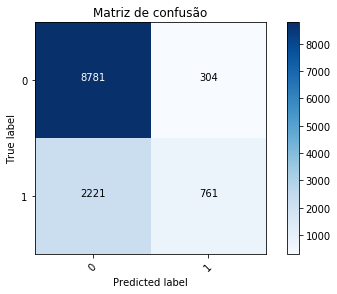

In [85]:
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False,
                      title='Matriz de confusão')

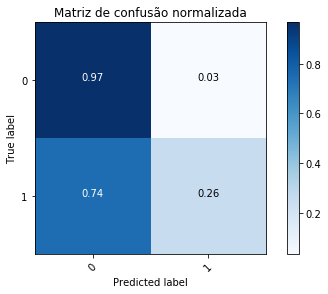

In [86]:
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Matriz de confusão normalizada')

### Classificação utilizando Random Forest Classifier

In [87]:
# Definição de parâmetros
i = 3
n_estimators = [500, 1000, 2000, 3000]
clf = RandomForestClassifier()

In [88]:
start = time.time()

gscv = GridSearchCV(clf, param_grid = {'n_estimators': n_estimators}, cv = i, n_jobs=-1)
gscv.fit(x_train,y_train)
y_pred = gscv.predict(x_test)
end = time.time()

print('RFC done in ' + str(end - start) + ' seconds!')

RFC done in 733.3147668838501 seconds!


#### Resultados

In [89]:
print("Accuracy: %0.2f" % (accuracy_score(y_pred, y_test)))
print("Precision: %0.2f" % (precision_score(y_pred, y_test)))
print("Recall: %0.2f" % (recall_score(y_pred, y_test)))
print("F Scoring: %0.2f" % ((f1_score(y_pred, y_test))))

Accuracy: 0.85
Precision: 0.65
Recall: 0.72
F Scoring: 0.68


In [90]:
cnf_matrix = confusion_matrix(y_test, y_pred)
class_names = [ "0","1" ]

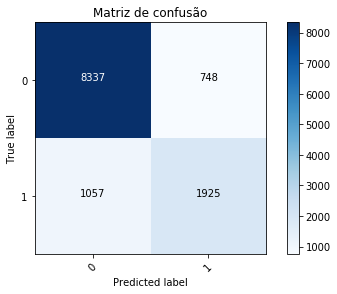

In [91]:
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False,
                      title='Matriz de confusão')

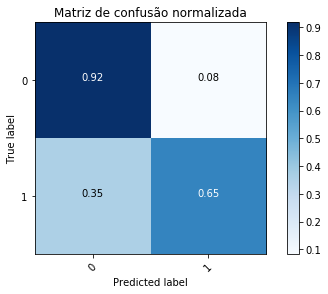

In [92]:
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Matriz de confusão normalizada')

### Predição dos objetos do arquivo test_X

In [93]:
y_pred = gscv.predict(df_test_values)

In [94]:
df_test_labels = pd.DataFrame(index = df_test_ids)
df_test_labels["label"] = list(y_pred)
df_test_labels.to_csv("data/test_Y.csv")